### Initialization

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
dtype = torch.cuda.FloatTensor
dtype_l = torch.cuda.LongTensor

### Data generator

In [70]:
class dataGenerator:
    def __init__(self):
        self.NUM_SAMPLES_train = int(10e6)
        self.NUM_SAMPLES_test = int(10e4)
        self.data_train = []
        self.data_test = []
        self.J = 3
        self.N = 50
        self.edge_density = 0.5
        self.clique_size = 10
        
    def ErdosRenyi(self, p, N):
        G = nx.erdos_renyi_graph(N, p)
        W = nx.adjacency_matrix(G).todense().astype(float)
        W = np.array(W)
        return W
      
    def plantedClique(self, p, N, C):
        W = self.ErdosRenyi(p, N)
        clique = np.random.choice(N, C, replace=False)
        for i in clique:
            for j in clique:
                if j != i:
                    W[i,j] = 1
        clique_labeling = np.zeros((N), dtype=np.int)
        for i in clique:
            clique_labeling[i] = 1
        return W, clique_labeling
      
    def find_max_clique_size(self, W):  
        G = nx.from_numpy_matrix(W)
        cliques = list(nx.find_cliques(G))
        if isinstance(cliques[0], int):
            return len(cliques)
        else:
            for i in range(len(cliques)):
                cliques[i] = len(cliques[i])
            return max(cliques)
      
    def average_clique(self, sample):
        sample_size = sample.shape[0]
        cliques = []
        for i in range(sample_size):
            cliques.append(self.find_max_clique_size(sample[i, :, :, 1].data.cpu().numpy()))
        return np.mean(cliques)
        
    def compute_operators(self, W):
        N = W.shape[0]
        # OP = operators: {Id, W, W^2, ..., W^{J-1}, D, U}
        deg = W.sum(1)
        D = np.diag(deg)
        W_pow = W.copy()
        OP = np.zeros([N, N, self.J + 2])
        OP[:, :, 0] = np.eye(N)
        for j in range(self.J):
            OP[:, :, j + 1] = W_pow.copy()
            # W_pow = np.minimum(np.dot(W_pow, W_pow), np.ones(W_pow.shape))
            W_pow = np.minimum(np.dot(W_pow, W), np.ones(W_pow.shape))
        OP[:, :, self.J] = D
        OP[:, :, self.J + 1] = np.ones((N, N)) * (1.0 / float(N))
        x = np.reshape(deg, (N, 1))
        return OP, x
        
    def compute_sample(self):
        sample = {}
        W, c = self.plantedClique(self.edge_density, self.N, self.clique_size)
        sample['OP'], sample['x'] = self.compute_operators(W)
        sample['c'] = c
        return sample
    
    def create_train_dataset(self):
        self.data_train = []
        for _ in range(self.NUM_SAMPLES_train):
            sample = self.compute_sample()
            self.data_train.append(sample)
            
    def create_test_dataset(self):
        self.data_test = []
        for _ in range(self.NUM_SAMPLES_test):
            sample = self.compute_sample()
            self.data_test.append(sample)
            
    def sample_batch(self, BATCH_SIZE, is_training=True, cuda=True, volatile=False):
        if is_training:
            data = self.data_train
        else:
            data = self.data_test
        OP_size = data[0]['OP'].shape
        x_size = data[0]['x'].shape
        c_size = data[0]['c'].shape
        
        OP = torch.zeros(OP_size).expand(BATCH_SIZE, *OP_size)
        x = torch.zeros(x_size).expand(BATCH_SIZE, *x_size)
        c = torch.zeros(c_size).expand(BATCH_SIZE, *c_size)
        
        for i in range(BATCH_SIZE):
            if is_training:
                ind = np.random.randint(0, len(data))
            else:
                ind = i
            OP[i] = torch.from_numpy(data[ind]['OP'])
            x[i] = torch.from_numpy(data[ind]['x'])
            c[i] = torch.from_numpy(data[ind]['c'])
            
        OP = Variable(OP, volatile=volatile)
        x = Variable(x, volatile=volatile)
        c = Variable(c, volatile=volatile)
        
        if cuda:
            return [OP.cuda(), x.cuda()], c.cuda()
        else:
            return [OP, x, c]
          
# Test

generator = dataGenerator()
generator.NUM_SAMPLES_train = 100
generator.NUM_SAMPLES_test = 100
generator.N = 50
J = 5
generator.J = J-2
generator.create_train_dataset()
generator.create_test_dataset()
G, c = generator.sample_batch(32)
print(G[0].shape,x.shape, c.shape)
print(G[0][0, :, :, 1])
print(G[1][0, :, 0], c[0, :])
print(sum(c[0,:].data.cpu().numpy()))
print(generator.average_clique(G[0]))

# Test: OK


torch.Size([32, 50, 50, 5]) torch.Size([32, 50, 1]) torch.Size([32, 50])
Variable containing:
    0     0     0  ...      1     1     1
    0     0     1  ...      1     1     0
    0     1     0  ...      1     0     0
       ...          ⋱          ...       
    1     1     1  ...      0     1     1
    1     1     0  ...      1     0     0
    1     0     0  ...      1     0     0
[torch.cuda.FloatTensor of size 50x50 (GPU 0)]

Variable containing:
 25
 26
 25
 23
 24
 28
 32
 21
 30
 24
 27
 19
 23
 28
 26
 28
 22
 22
 23
 31
 23
 21
 27
 27
 24
 29
 22
 25
 25
 31
 34
 24
 26
 28
 24
 30
 25
 27
 23
 26
 27
 30
 26
 27
 19
 35
 25
 33
 29
 23
[torch.cuda.FloatTensor of size 50 (GPU 0)]
 Variable containing:
 0
 0
 0
 0
 0
 1
 1
 0
 1
 0
 0
 0
 0
 1
 1
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
 0
 0
 0
[torch.cuda.FloatTensor of size 50 (GPU 0)]

10.0
10.0


### GNN Model

In [71]:
def gmul(input):
    W, x = input
    # x is a tensor of size (bs, N, num_features)
    # W is a tensor of size (bs, N, N, J)
    N = W.size()[-2]
    W = W.split(1, 3) # W is a list of J tensors of size (bs, N, N, 1)
    W = torch.cat(W, 1).squeeze(3) # W is now a tensor of size (bs, J*N, N)
    output = torch.bmm(W, x) # matrix multiplication (J*N,N) x (N,num_features): output has size (bs, J*N, num_features)
    output = output.split(N, 1) # output is a list of J tensors of size (bs, N, num_features)
    output = torch.cat(output, 2)
    # output has size (bs, N, J*num_features)
    return output

class Gconv(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc1 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.fc2 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.bn = nn.BatchNorm1d(self.num_outputs)

    def forward(self, input):
        W = input[0]
        x = gmul(input) # x has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous() # makes sure that x is stored in a contiguous chunk of memory
        x = x.view(-1, self.num_inputs)
        x1 = F.relu(self.fc1(x)) # x_1 has size (bs*N, num_outputs // 2)
        x2 = self.fc2(x) # x_2 has size (bs*N, num_outputs // 2)
        x = torch.cat((x1, x2), 1) # x has size (bs*N, num_outputs)
        x = self.bn(x)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        return W, x
      
class Gconv_last(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv_last, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc = nn.Linear(self.num_inputs, self.num_outputs) # the only difference is that there is no activations layer

    def forward(self, input):
        W = input[0]
        x = gmul(input) # out has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous()
        x = x.view(x_size[0]*x_size[1], -1) # x has size (bs*N, num_inputs)
        x = self.fc(x) # x has size (bs*N, num_outputs)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        x = x.squeeze(2)
        # x = x.permute(0, 2, 1) # x has size (bs, num_outputs=2, N)
        return W, x

class GNN(nn.Module):
    def __init__(self, num_features, num_layers, J):
        super(GNN, self).__init__()
        self.num_features = num_features
        self.num_layers = num_layers
        self.featuremap_first = [1, num_features]
        self.featuremap = [num_features, num_features]
        self.featuremap_last = [num_features, 1]
        self.layer0 = Gconv(self.featuremap_first, J)
        for i in range(num_layers):
            module = Gconv(self.featuremap, J)
            self.add_module('layer{}'.format(i + 1), module)
        self.layerlast = Gconv_last(self.featuremap_last, J)

    def forward(self, input):
        cur = self.layer0(input)
        for i in range(self.num_layers):
            cur = self._modules['layer{}'.format(i+1)](cur)
        out = self.layerlast(cur)
        return out[1]
      
def predict_clique(y):
    return torch.ge(y, 0.5).type(dtype)
  
# Test

num_features = 10
num_layers = 5
gnn = GNN(num_features, num_layers, J).type(dtype)
G, c = generator.sample_batch(32)
out = gnn(G)
print(out.size(), c.size())
print(predict_clique(out))

# Test: OK

torch.Size([32, 50]) torch.Size([32, 50])
Variable containing:
    0     1     0  ...      0     0     1
    0     1     0  ...      0     0     1
    0     1     0  ...      0     0     1
       ...          ⋱          ...       
    0     1     0  ...      0     0     1
    0     1     0  ...      0     0     1
    0     1     0  ...      0     0     1
[torch.cuda.FloatTensor of size 32x50 (GPU 0)]



### Loss function

In [72]:
base_loss = nn.BCEWithLogitsLoss()

def compute_loss(pred, labels):
    pred = pred.view(-1)
    labels = labels.view(-1)
    return base_loss(pred, labels)
  
# Test

print(compute_loss(out,c))

# Test: OK

Variable containing:
 1.3418
[torch.cuda.FloatTensor of size 1 (GPU 0)]



### Optimizer

In [0]:
def get_optimizer(model):
    optimizer = optim.Adam(model.type(dtype).parameters(), lr=1e-3)
    return optimizer

### Logger

In [0]:
def compute_recovery_rate(pred, labels):
    pred = predict_clique(pred)
    error = 1 - torch.eq(pred, labels).type(dtype)
    frob_norm = error.mean(1)
    accuracy = 1 - frob_norm
    accuracy = accuracy.mean(0).squeeze()
    return accuracy.data.cpu().numpy()[0]

class make_logger(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.accuracy_train = []
        self.accuracy_test = []
        self.args = {}

    def add_train_loss(self, loss):
        self.loss_train.append(loss.data.cpu().numpy())

    def add_test_loss(self, loss):
        self.loss_test.append(loss.data.cpu().numpy())

    def add_train_accuracy(self, pred, labels):
        accuracy = compute_recovery_rate(pred, labels)
        self.accuracy_train.append(accuracy)

    def add_test_accuracy(self, pred, labels):
        accuracy = compute_recovery_rate(pred, labels)
        self.accuracy_test.append(accuracy)

    def plot_train_loss(self):
        plt.figure(0)
        plt.clf()
        iters = range(len(self.loss_train))
        plt.semilogy(iters, self.loss_train, 'b')
        plt.xlabel('iterations')
        plt.ylabel('Cross Entropy Loss')
        plt.title('Training Loss: p={}, C={}'.format(self.args['edge density'], self.args['planted clique size']))

    def plot_train_accuracy(self):
        plt.figure(1)
        plt.clf()
        iters = range(len(self.accuracy_train))
        plt.plot(iters, self.accuracy_train, 'b')
        plt.xlabel('iterations')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy: p={}, C={}'.format(self.args['edge density'], self.args['planted clique size']))

### Trainer

Dataset created
Iter: 0, Loss: 1.123
Iter: 100, Loss: 0.02266
Iter: 200, Loss: 0.01887
Iter: 300, Loss: 0.004496
Iter: 400, Loss: 0.07645
Iter: 500, Loss: 0.005446
Iter: 600, Loss: 0.00678
Iter: 700, Loss: 0.1283
Iter: 800, Loss: 0.0603
Iter: 900, Loss: 0.1136
Iter: 1000, Loss: 0.01789
Iter: 1100, Loss: 0.004448
Iter: 1200, Loss: 0.001516
Iter: 1300, Loss: 0.002435
Iter: 1400, Loss: 0.00129
Iter: 1500, Loss: 0.002858
Iter: 1600, Loss: 0.009459
Iter: 1700, Loss: 0.0006285
Iter: 1800, Loss: 0.01029
Iter: 1900, Loss: 0.001058
Optimization finished.


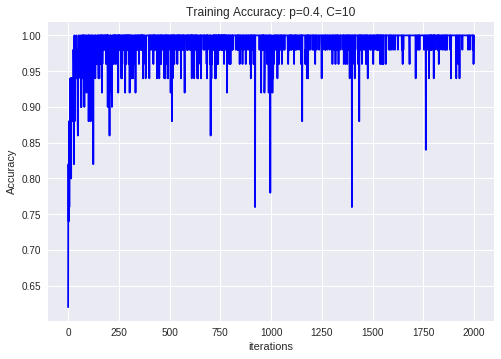

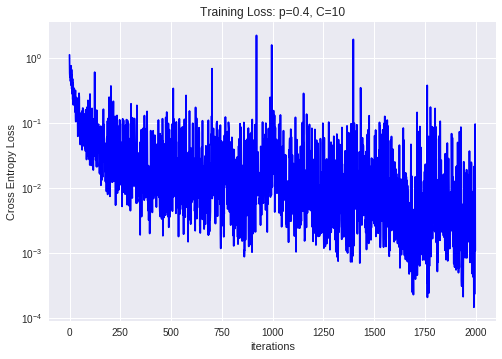

In [76]:
def train(model, generator, logger, iterations=60000, batch_size=32, clip_grad_norm=40.0, print_freq=100):
    # model should be a gnn
    # generator is the data_generator
    optimizer = get_optimizer(model)
    for iter_count in range(iterations):
        G, labels = generator.sample_batch(batch_size)
        pred = model(G)
        loss = compute_loss(pred, labels)
        model.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip_grad_norm)
        optimizer.step()
        logger.add_train_loss(loss)
        logger.add_train_accuracy(pred, labels)
        if iter_count % print_freq == 0:
            print('Iter: {}, Loss: {:.4}'.format(iter_count,loss.data[0]))
    logger.plot_train_accuracy()
    logger.plot_train_loss()
    print('Optimization finished.')
    
# Test

args = {'edge density' : 0.4, 'planted clique size' : 10}
logger = make_logger()
logger.args = args
generator = dataGenerator()
generator.edge_density = args['edge density']
generator.clique_size = args['planted clique size']
generator.NUM_SAMPLES_train = 1000
generator.N = 50
J = 5
generator.J = J-2
generator.create_train_dataset()
print('Dataset created')
num_features = 10
num_layers = 5
gnn = GNN(num_features, num_layers, J).type(dtype)
train(gnn, generator, logger, iterations=2000, batch_size=32)

# Test: OK

### Main


Dataset created
Iter: 0, Loss: 1.27
Iter: 100, Loss: 0.3192
Iter: 200, Loss: 0.3292
Iter: 300, Loss: 0.3814
Iter: 400, Loss: 0.337
Iter: 500, Loss: 0.4735
Iter: 600, Loss: 0.4345
Iter: 700, Loss: 0.4006
Iter: 800, Loss: 0.3967
Iter: 900, Loss: 0.3018
Iter: 1000, Loss: 0.3483
Iter: 1100, Loss: 0.3304
Iter: 1200, Loss: 0.3093
Iter: 1300, Loss: 0.3311
Iter: 1400, Loss: 0.339
Iter: 1500, Loss: 0.2803
Iter: 1600, Loss: 0.3469
Iter: 1700, Loss: 0.3781
Iter: 1800, Loss: 0.2966
Iter: 1900, Loss: 0.4529
Iter: 2000, Loss: 0.3241
Iter: 2100, Loss: 0.3261
Iter: 2200, Loss: 0.3106
Iter: 2300, Loss: 0.3516
Iter: 2400, Loss: 0.4759
Iter: 2500, Loss: 0.3719
Iter: 2600, Loss: 0.3218
Iter: 2700, Loss: 0.4645
Iter: 2800, Loss: 0.3159
Iter: 2900, Loss: 0.3058
Iter: 3000, Loss: 0.3517
Iter: 3100, Loss: 0.3571
Iter: 3200, Loss: 0.3195
Iter: 3300, Loss: 0.339
Iter: 3400, Loss: 0.3035
Iter: 3500, Loss: 0.2974
Iter: 3600, Loss: 0.4156
Iter: 3700, Loss: 0.3033
Iter: 3800, Loss: 0.305
Iter: 3900, Loss: 0.357
Ite

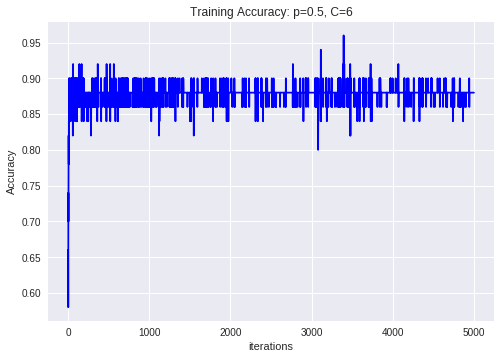

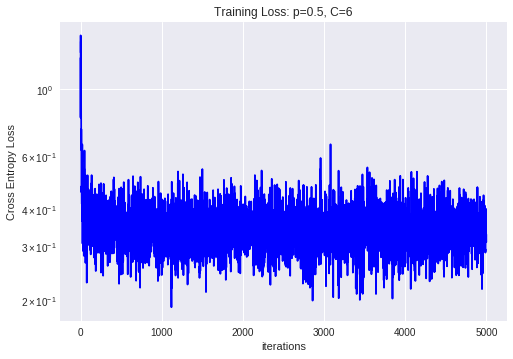

In [77]:
args = {'edge density' : 0.5, 'planted clique size' : 6}
logger = make_logger()
logger.args = args
generator = dataGenerator()
generator.edge_density = args['edge density']
generator.clique_size = args['planted clique size']
generator.NUM_SAMPLES_train = 20000
generator.N = 50
J = 6
generator.J = J-2
generator.create_train_dataset()
print('Dataset created')
num_features = 20
num_layers = 20
gnn = GNN(num_features, num_layers, J).type(dtype)
train(gnn, generator, logger, iterations=5000, batch_size=32)

### Test

In [86]:
def test(model, generator, logger):
    # model should be a gnn
    # generator is the data_generator
    G, labels = generator.sample_batch(generator.NUM_SAMPLES_test, is_training=False)
    pred = model(G)
    logger.loss_test = []
    logger.accuracy_test = []
    for i in range(generator.NUM_SAMPLES_test):
        loss = compute_loss(pred[i,:], labels[i,:])
        logger.add_test_loss(loss)
    logger.add_test_accuracy(pred, labels)
        
    print('Test Loss: {:.4}'.format(np.mean(logger.loss_test)))
    print('Test Accuracy: {:.4}'.format(np.mean(logger.accuracy_test)))

generator.NUM_SAMPLES_test = 1000
generator.create_test_dataset()
print('Test dataset created')
test(gnn, generator, logger)

Test dataset created
Test Loss: 0.3066
Test Accuracy: 0.88
